# Deep Hedging
### Vanilla Deep Hedging engine with dynamic training update.
Hans Buehler, June 30 2022


Deep Hedging Engine: first of 10 epochs for 10000 samples / 1000 validation samples started ...  

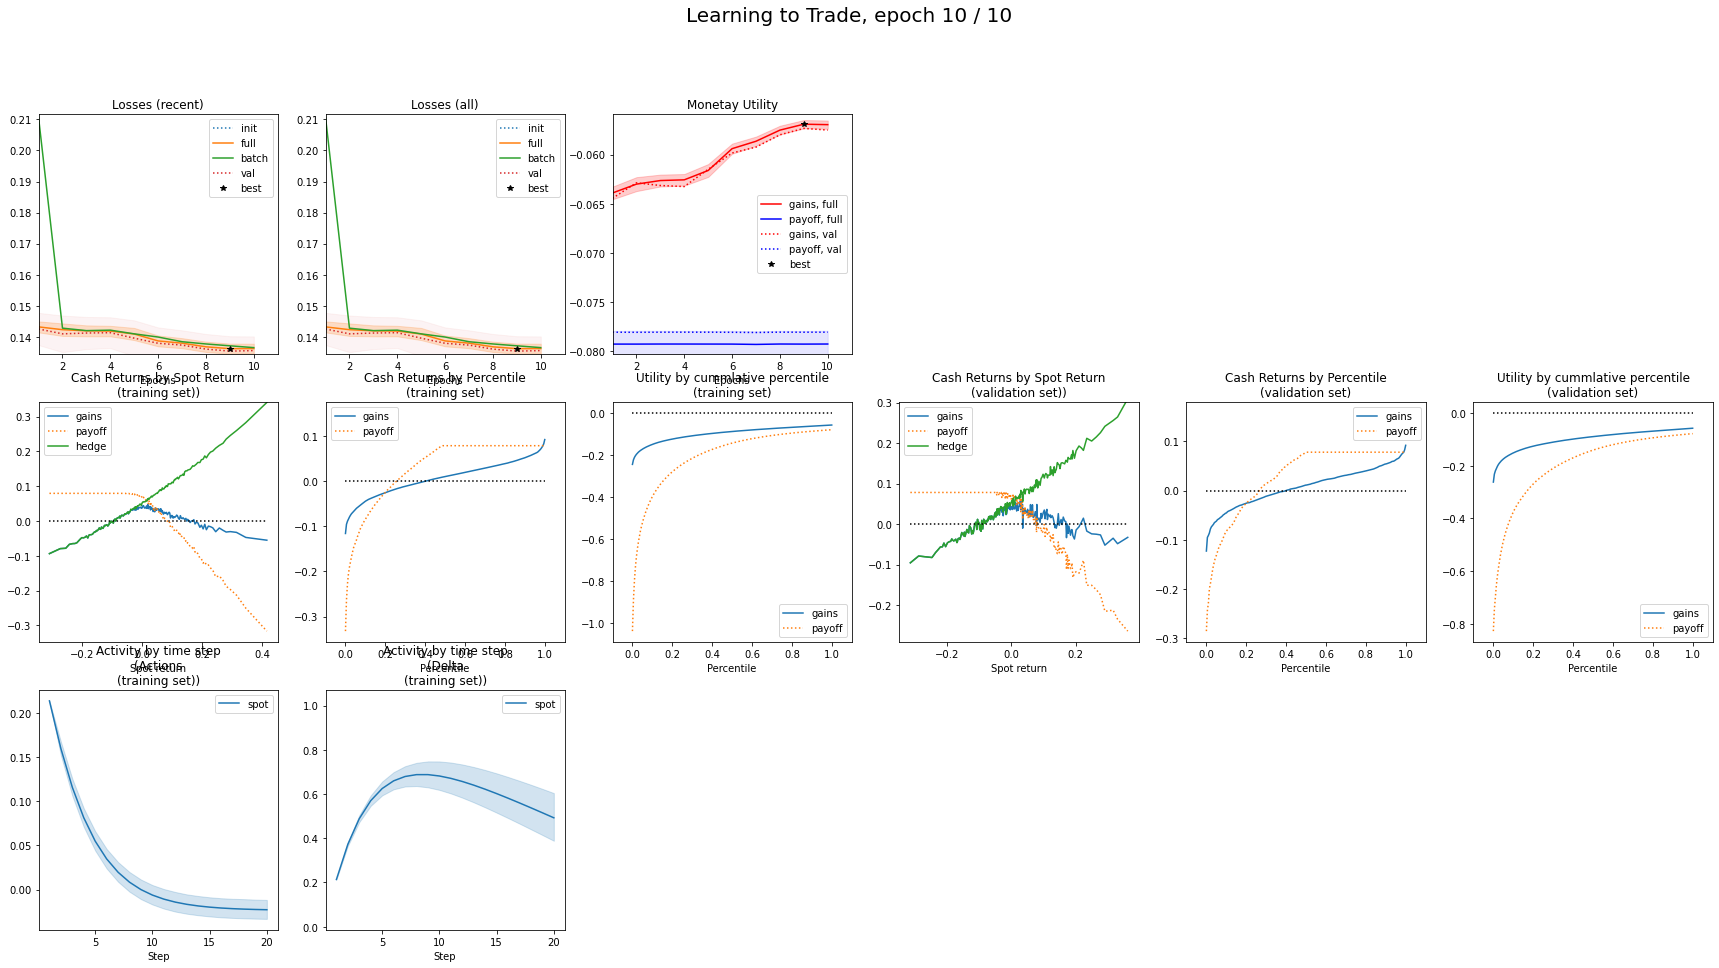

Training 10/10 epochs; 10000 samples; 1000 validation samples batch size 32 | initial loss 2.01299 (0.0470358), full 0.136247 (0.00155927), best 0.13621 (0.0470358), batch 0.13655, val 0.135592 (0.00456048). Best batch 8 | time elapsed 1:22; estimated time remaining 8s    
 Status: Ran all 10 epochs

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.agent.network['width'] = 20 # Network width; default: 20
config.gym.agent['agent_type'] = feed_forward #  Default: feed_forward
config.gym.agent['features'] = ['price', 'delta', 'time_left'] # Named features the agent uses from the environment; default: ['price', 'delta', 'time_left']
config.gym.environment['softclip_hinge_softness'] = 1.0 # Specifies softness

In [8]:
"""
When working on the code base, activate below code:

import imp
import deephedging.base as base
imp.reload(base)
import deephedging.world as world
imp.reload(world)
import deephedging.agents as agents
imp.reload(agents)
import deephedging.objectives as objectives
imp.reload(objectives)
import deephedging.gym as gym
imp.reload(gym)
import deephedging.trainer as trainer
imp.reload(trainer)
"""

from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 10
config.trainer.train.run_eagerly = False
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.pcnt_lo = 0.25
config.trainer.visual.pcnt_hi = 0.75

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
